In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

def get_drawdown(p):
    """
    计算净值回撤
    """
    T = len(p)
    hmax = [p[0]]
    for t in range(1, T):
        hmax.append(np.nanmax([p[t], hmax[t - 1]]))
    dd = [p[t] / hmax[t] - 1 for t in range(T)]

    return dd


def cal_period_perf_indicator(adjnav):
    """
    计算区间业绩指标:输入必须是日频净值
    """

    if type(adjnav) == pd.DataFrame:
        res = pd.DataFrame(index=adjnav.columns, columns=['AnnRet', 'AnnVol', 'SR', 'MaxDD', 'Calmar'])
        for col in adjnav:
            res.loc[col] = cal_period_perf_indicator(adjnav[col])
        res = res.applymap(float_to_percent)
        return res

    ret = adjnav.pct_change()
    #annret = np.nanmean(ret) * 242 # 单利
    annret = (adjnav[-1] / adjnav[0]) ** (242/len(adjnav)) - 1 # 复利
    annvol = np.nanstd(ret) * np.sqrt(242)
    sr = annret / annvol
    dd = get_drawdown(adjnav)
    mdd = np.nanmin(dd)
    calmar = annret / -mdd

    return [annret, annvol, sr, mdd, calmar]

def datestr2dtdate(datestr):
    # 日期格式转换：'yyyy-mm-dd'转为datetime.date
    return datetime.datetime.strptime(datestr, '%Y-%m-%d').date()

# Define a formatting function to convert float to percentage
def float_to_percent(x):
    return "{:.2%}".format(x)


In [5]:
index_price = pd.read_csv('../Data/USD ETFs_open.csv').set_index('datetime')
index_price.index = [datestr2dtdate(e) for e in index_price.index]

In [9]:
df.index.tolist()

[datetime.date(2010, 1, 4),
 datetime.date(2010, 1, 5),
 datetime.date(2010, 1, 6),
 datetime.date(2010, 1, 7),
 datetime.date(2010, 1, 8),
 datetime.date(2010, 1, 11),
 datetime.date(2010, 1, 12),
 datetime.date(2010, 1, 13),
 datetime.date(2010, 1, 14),
 datetime.date(2010, 1, 15),
 datetime.date(2010, 1, 19),
 datetime.date(2010, 1, 20),
 datetime.date(2010, 1, 21),
 datetime.date(2010, 1, 22),
 datetime.date(2010, 1, 25),
 datetime.date(2010, 1, 26),
 datetime.date(2010, 1, 27),
 datetime.date(2010, 1, 28),
 datetime.date(2010, 1, 29),
 datetime.date(2010, 2, 1),
 datetime.date(2010, 2, 2),
 datetime.date(2010, 2, 3),
 datetime.date(2010, 2, 4),
 datetime.date(2010, 2, 5),
 datetime.date(2010, 2, 8),
 datetime.date(2010, 2, 9),
 datetime.date(2010, 2, 10),
 datetime.date(2010, 2, 11),
 datetime.date(2010, 2, 12),
 datetime.date(2010, 2, 16),
 datetime.date(2010, 2, 17),
 datetime.date(2010, 2, 18),
 datetime.date(2010, 2, 19),
 datetime.date(2010, 2, 22),
 datetime.date(2010, 2, 23

,AnnRet,AnnVol,SR,MaxDD,Calmar
TAN,-2.63%,32.86%,-8.01%,-17.95%,-14.66%
SPY,26.83%,15.57%,172.30%,-7.97%,336.75%
stgy,-15.89%,22.80%,-69.67%,-18.52%,-85.75%


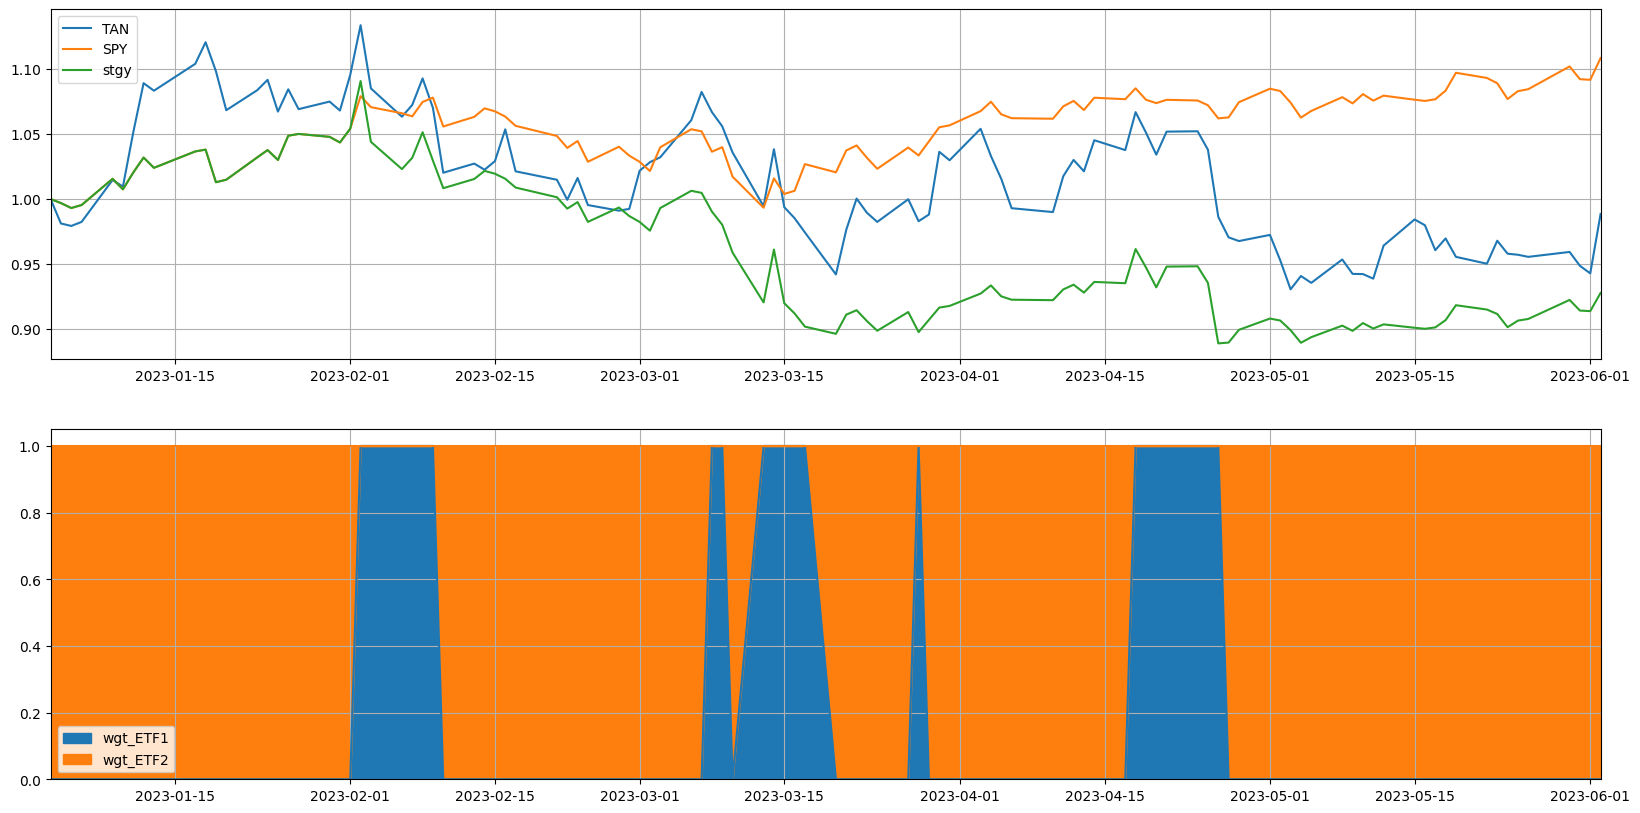

In [11]:
# 二八轮动：满仓版本
ETF1 = 'SCHE'
ETF2 = 'SPY'
weight = 0.8
start_date = datetime.date(2023,1,1)
N = 20
df = index_price.copy()
df = df[df.index>start_date]
df['ret_ETF1'] = df[ETF1].pct_change()
df['ret_ETF2'] = df[ETF2].pct_change()
df['N_day_ret_ETF1'] = df[ETF1] / df[ETF1].shift(N) - 1
df['N_day_ret_ETF2'] = df[ETF2] / df[ETF2].shift(N) - 1        
df['momentum_ETF1_vs_ETF2'] = df['N_day_ret_ETF1'] - df['N_day_ret_ETF2']
df['wgt_ETF1'] = [1 if e>0 else 0 for e in df['momentum_ETF1_vs_ETF2'].shift(1)]
df['wgt_ETF2'] = 1 - df['wgt_ETF1']
df['ret_stgy'] = df['ret_ETF1'] * df['wgt_ETF1'] + df['ret_ETF2'] * df['wgt_ETF2']
df[ETF1] = (1+df['ret_ETF1']).cumprod().fillna(1)
df[ETF2] = (1+df['ret_ETF2']).cumprod().fillna(1)
df['stgy'] = (1+df['ret_stgy']).cumprod().fillna(1)

fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(2,1,1)
df.loc[:,[ETF1, ETF2, 'stgy']].plot(ax=ax1, grid=True)
plt.xlim(df.index[0],df.index[-1])

ax2 = fig.add_subplot(2,1,2)
df[['wgt_ETF1', 'wgt_ETF2']].plot(ax=ax2, kind='area', stacked=True, grid=True)
plt.xlim(df.index[0],df.index[-1])
    
res = cal_period_perf_indicator(df.loc[:,[ETF1, ETF2, 'stgy']])
res



,AnnRet,AnnVol,SR,MaxDD,Calmar
TAN,-5.16%,40.61%,-12.70%,-95.29%,-5.41%
SPY,8.66%,19.14%,45.25%,-55.19%,15.70%
stgy,8.81%,24.89%,35.39%,-50.96%,17.29%


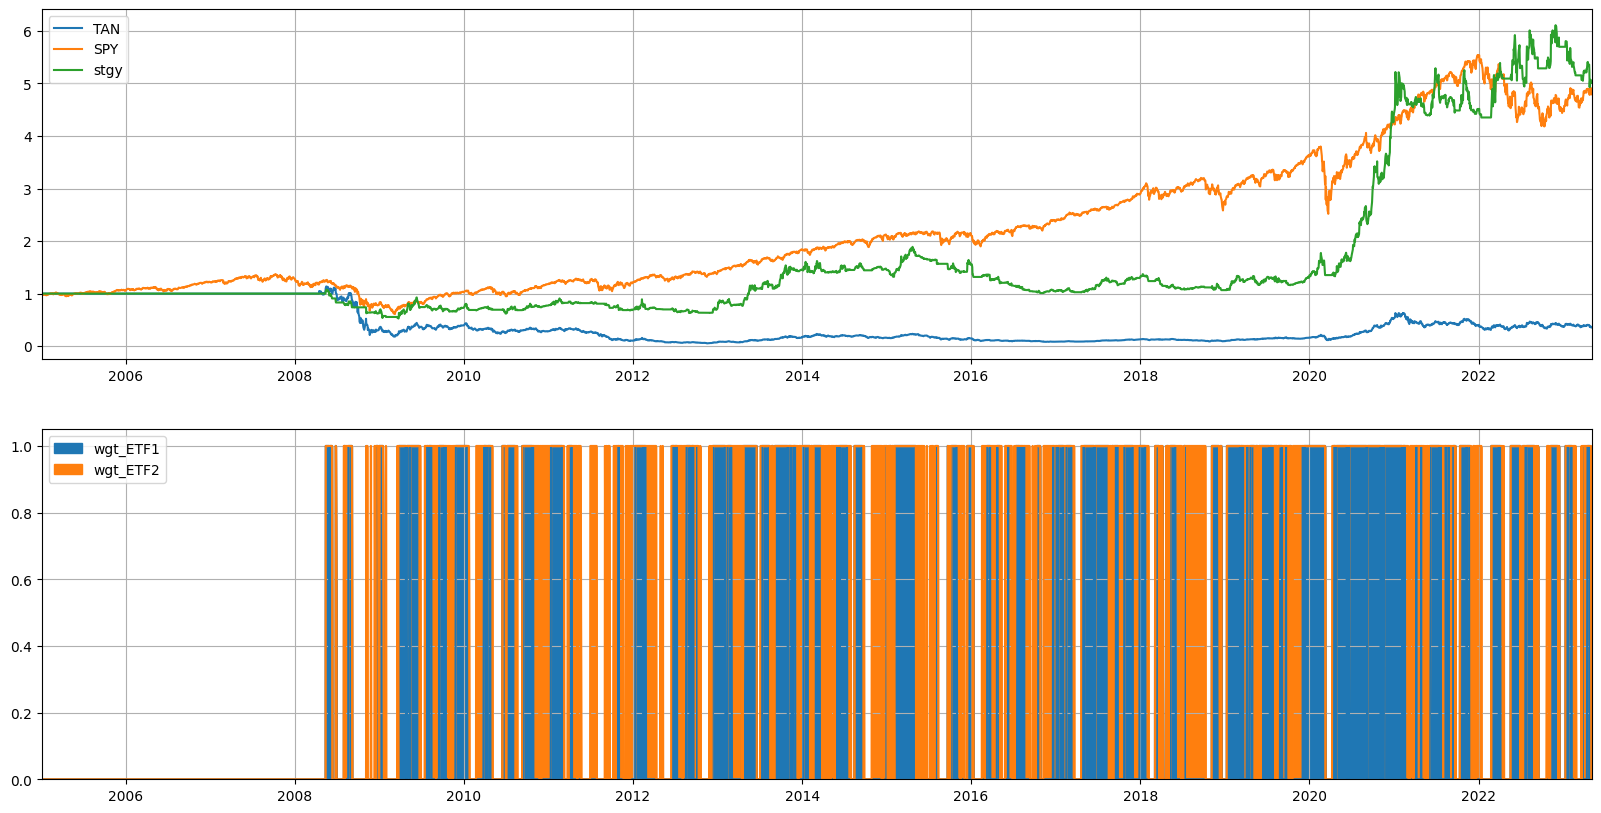

In [13]:

# 二八轮动：有空仓版
N = 20
df = index_price.copy()
df['ret_ETF1'] = df[ETF1].pct_change()
df['ret_ETF2'] = df[ETF2].pct_change()
df['N_day_ret_ETF1'] = df[ETF1] / df[ETF1].shift(N) - 1
df['N_day_ret_ETF2'] = df[ETF2] / df[ETF2].shift(N) - 1

df['wgt_ETF1'] = 0
df['wgt_ETF2'] = 0
for i in range(1,len(df)):
    t = df.index[i]
    t0 = df.index[i-1]
    if df.loc[t0,'N_day_ret_ETF1']>=df.loc[t0,'N_day_ret_ETF2'] and df.loc[t0,'N_day_ret_ETF1']>0:
        df.loc[t,'wgt_ETF1'] = 1
    elif df.loc[t0,'N_day_ret_ETF2']>df.loc[t0,'N_day_ret_ETF1'] and df.loc[t0,'N_day_ret_ETF2']>0:
        df.loc[t,'wgt_ETF2'] = 1
        
df['ret_stgy'] = df['ret_ETF1'] * df['wgt_ETF1'] + df['ret_ETF2'] * df['wgt_ETF2']
df[ETF1] = (1+df['ret_ETF1']).cumprod().fillna(1)
df[ETF2] = (1+df['ret_ETF2']).cumprod().fillna(1)
df['stgy'] = (1+df['ret_stgy']).cumprod().fillna(1)

fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(2,1,1)
df.loc[:,[ETF1, ETF2, 'stgy']].plot(ax=ax1, grid=True)
plt.xlim(df.index[0],df.index[-1])

ax2 = fig.add_subplot(2,1,2)
df[['wgt_ETF1', 'wgt_ETF2']].plot(ax=ax2, kind='area', stacked=True, grid=True)
plt.xlim(df.index[0],df.index[-1])
    
res = cal_period_perf_indicator(df.loc[:,[ETF1, ETF2, 'stgy']])
res

,AnnRet,AnnVol,SR,MaxDD,Calmar
SCHE,3.88%,14.48%,26.82%,-11.88%,32.69%
SPY,26.83%,15.57%,172.30%,-7.97%,336.75%
stgy,13.40%,14.65%,91.44%,-8.45%,158.48%


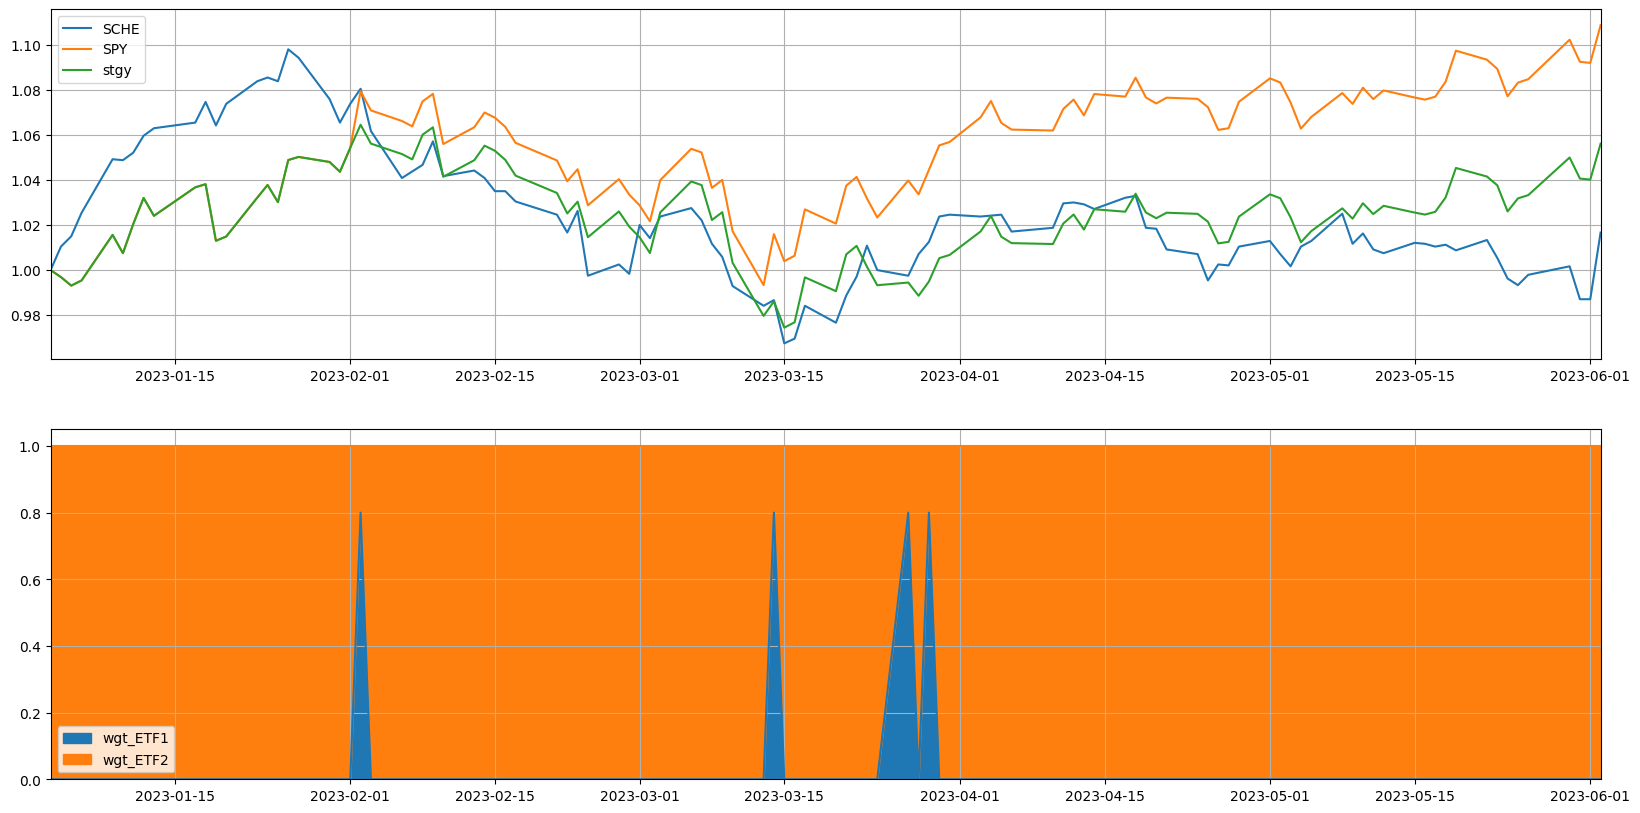

In [13]:
# Rotation with RRG Signal
ETF1 = 'SCHE'
ETF2 = 'SPY'
weight = 0.8
start_date = datetime.date(2023,1,1)
N = 20
df = index_price.copy()
df = df[df.index>start_date]
df['ret_ETF1'] = df[ETF1].pct_change()
df['ret_ETF2'] = df[ETF2].pct_change()
df['N_day_ret_ETF1'] = df[ETF1] / df[ETF1].shift(N) - 1
df['N_day_ret_ETF2'] = df[ETF2] / df[ETF2].shift(N) - 1        
df['momentum_ETF1_vs_ETF2'] = df['N_day_ret_ETF1'] - df['N_day_ret_ETF2']
df['wgt_ETF1'] = [1*weight if e>0 else 0 for e in df['momentum_ETF1_vs_ETF2'].shift(1)]
df['wgt_ETF2'] = 1 - df['wgt_ETF1']
df['ret_stgy'] = df['ret_ETF1'] * df['wgt_ETF1'] + df['ret_ETF2'] * df['wgt_ETF2']
df[ETF1] = (1+df['ret_ETF1']).cumprod().fillna(1)
df[ETF2] = (1+df['ret_ETF2']).cumprod().fillna(1)
df['stgy'] = (1+df['ret_stgy']).cumprod().fillna(1)

fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(2,1,1)
df.loc[:,[ETF1, ETF2, 'stgy']].plot(ax=ax1, grid=True)
plt.xlim(df.index[0],df.index[-1])

ax2 = fig.add_subplot(2,1,2)
df[['wgt_ETF1', 'wgt_ETF2']].plot(ax=ax2, kind='area', stacked=True, grid=True)
plt.xlim(df.index[0],df.index[-1])
    
res = cal_period_perf_indicator(df.loc[:,[ETF1, ETF2, 'stgy']])
res

